In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import socket
from PIL import Image
import time
import functools
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as keras_process
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import random



In [53]:

s= socket.socket()
print("Socket Created")
port =12345
s.bind(("localhost",port))
print("Socket binded")
s.listen(5)
txt=""
while True:
    c,addr =s.accept()
    txt=c.recv(1024).decode()
    break
path=txt.split(',')


Socket Created
Socket binded


In [54]:
content_path =path[0] #CHANGE PATH TO PULL IMAGES FROM GUI
style_path = path[1]


In [55]:
def load_img(path):
  max_dim = 512
  img = Image.open(path)
  
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = keras_process.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img


def imshow(img, title=None):
 
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)


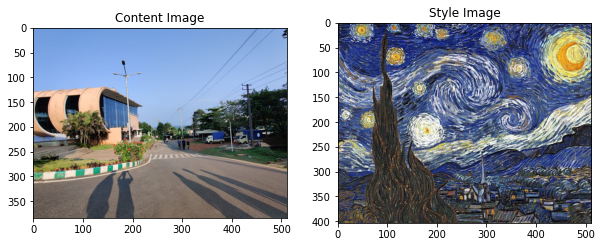

In [56]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()   


In [57]:
def load_and_process_img(path):
  img = load_img(path)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [58]:
resnet = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
resnet.summary()
for layer in resnet.layers:
  print(layer.name)


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [59]:
#TRIAL WITH BOTH CONV AND RELU LAYERS
import random
content_layers = ['conv4_block2_2_conv']
style_layers_dict = {1:'conv1_relu',
                2:'conv2_block1_1_conv', 
                3:'conv2_block2_1_relu', 
                4:'conv2_block2_1_relu', 
                5:'conv2_block3_3_conv',
                6:'conv2_block2_2_relu',
                7:'conv4_block2_1_conv',
                8:'conv2_block2_1_relu', 
                9:'conv2_block2_1_relu', 
                10:'conv2_block3_3_conv',
                11:'conv2_block2_2_relu',
                12:'conv4_block2_1_relu',
                13:'conv4_block2_2_conv',
                14:'conv4_block2_2_relu',
                15:'conv4_block2_3_conv',
}
style_keys = []
style_layers = []
k = random.randint(1,15)
for i in range(k):
  style_keys.append(random.randint(1,15))
  # style_keys.append(i)

print(style_keys)

for i in range(k):
  layer = style_layers_dict[style_keys[i]]
  style_layers.append(layer)

print(style_layers)
  
layers = (content_layers,style_layers)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


[11, 9, 13, 3, 13, 2, 5, 2, 2, 9]
['conv2_block2_2_relu', 'conv2_block2_1_relu', 'conv4_block2_2_conv', 'conv2_block2_1_relu', 'conv4_block2_2_conv', 'conv2_block1_1_conv', 'conv2_block3_3_conv', 'conv2_block1_1_conv', 'conv2_block1_1_conv', 'conv2_block2_1_relu']


In [60]:
def get_model():
  
  # Load our model. We load pretrained ResNet50, trained on imagenet data
  resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
  resnet.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [resnet.get_layer(name).output for name in style_layers]
  content_outputs = [resnet.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(resnet.input, model_outputs)

In [61]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [62]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [63]:

def get_feature_representations(model, content_path, style_path):
  
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
    
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features


In [64]:

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
  
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  
  loss = style_score + content_score 
  return loss, style_score, content_score

In [65]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e7, 
                       style_weight=1e7): 
   
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
   
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
 
  opt = tf.optimizers.Adam(learning_rate=20, beta_1=0.99, epsilon=1e-1)
  
 
  best_loss, best_img = float('inf'), None
  
  
  loss_weights = (style_weight, content_weight)

    

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations+1):
    with tf.GradientTape() as tape: 
      all_loss = compute_loss(model, loss_weights, init_image, gram_style_features, content_features)
      total_loss = all_loss[0]
      grads_computed= tape.gradient(total_loss, init_image), all_loss
      grads, all_loss = grads_computed
      loss, style_score, content_score = all_loss
      opt.apply_gradients([(grads, init_image)])
      clipped = tf.clip_by_value(init_image, min_vals, max_vals)
      init_image.assign(clipped)
      end_time = time.time() 
    
    print(". ", end="") 
     
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())


    
    if i%10==0:
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
          'style loss: {:.4e}, '
          'content loss: {:.4e}'.format(loss, style_score, content_score))
    
    if i==num_iterations:
        imgs.append(plot_img)

  IPython.display.clear_output(wait=True)
  # plt.figure(figsize=(50,50))
  # print(len(imgs))
  # for i,img in enumerate(imgs):
  #     plt.subplot(2,2,i+1)
  #     plt.imshow(img)
      
  return best_img, best_loss

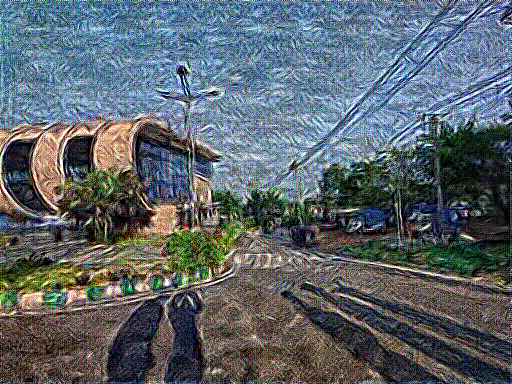

Iteration: 200
Total loss: 5.7687e+05, style loss: 1.7080e+05, content loss: 4.0608e+05


In [67]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e7, 
                       style_weight=1e7): 
   
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
   
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
 
  opt = tf.optimizers.Adam(learning_rate=20, beta_1=0.99, epsilon=1e-1)
  
 
  best_loss, best_img = float('inf'), None
  
  
  loss_weights = (style_weight, content_weight)

    

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations+1):
    with tf.GradientTape() as tape: 
      all_loss = compute_loss(model, loss_weights, init_image, gram_style_features, content_features)
      total_loss = all_loss[0]
      grads_computed= tape.gradient(total_loss, init_image), all_loss
      grads, all_loss = grads_computed
      loss, style_score, content_score = all_loss
      opt.apply_gradients([(grads, init_image)])
      clipped = tf.clip_by_value(init_image, min_vals, max_vals)
      init_image.assign(clipped)
      end_time = time.time() 
    
    print(". ", end="") 
     
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())


    
    if i%10==0:
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
          'style loss: {:.4e}, '
          'content loss: {:.4e}'.format(loss, style_score, content_score))
    
    if i==num_iterations:
        imgs.append(plot_img)

  IPython.display.clear_output(wait=True)
  # plt.figure(figsize=(50,50))
  # print(len(imgs))
  # for i,img in enumerate(imgs):
  #     plt.subplot(2,2,i+1)
  #     plt.imshow(img)
      
  return best_img, best_loss

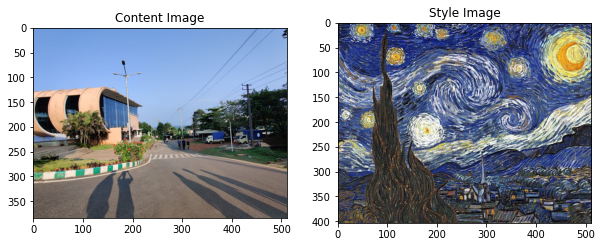

In [68]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()   